### **Beijing PM2.5 Dataset for classification**

**Abstract:** 
<p>This hourly data set contains the PM2.5 data of US Embassy in Beijing. Meanwhile, meteorological data from Beijing Capital International Airport are also included.</p>

**Attribute Information:**

|Attributte| Explanation                 ||Attributte| Explanation          |
|  :----   | :----                       ||  :----   | :----                |
|No.       | row number                  ||DEWP.| Dew Point (â„ƒ)           | 
|year.     | year of data in this row    ||TEMP | Temperature (â„ƒ)         | 
|month.    | month of data in this row   ||PRES.| Pressure (hPa)            | 
|day.      | day of data in this row     ||cbwd.| Combined wind direction   | 
|hour.     | hour of data in this row    ||Iws. | Cumulated wind speed (m/s)| 
|pm2.5.    | PM2.5 concentration (ug/m^3)||Is.  | Cumulated hours of snow   | 
|.         |                             ||Ir.  | Cumulated hours of rain   | 

**Data source:**
<p>Liang, X., Zou, T., Guo, B., Li, S., Zhang, H., Zhang, S., Huang, H. and Chen, S. X. (2015). Assessing Beijing's PM2.5 pollution: severity, weather impact, APEC and winter heating. Proceedings of the Royal Society A, 471, 20150257.</p>

In [159]:
# Environment Preparation
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

1.15.2


**Data Pre-processing:**

*   Data Cleaning
*   Feature Selection
*   Data Split
*   Data Normalisation


In [160]:
import pandas as pd
import numpy as np
import datetime
import time
from matplotlib import pyplot
import math
import random

# read data from csv file and process X, y
def data_loader(data_path):
		# load raw data
		df = pd.read_csv(data_path)

		# clean data with missing values          
		'''drop the rows directly -> mess up the order
			first 24 rows have pm2.5 value that is NaN -> discard
			else: forward filling'''
		df = df[24:].fillna(method='ffill')

		# integrate 'year', 'month', 'day', 'hour', 'No' as one attribute
		df['time'] = df.apply(lambda x : datetime.datetime(year=x['year'], month=x['month'], day=x['day'], hour=x['hour']), axis=1)
		df.drop(columns=['year', 'month', 'day', 'hour', 'No'], inplace=True)
		df = df.set_index('time')

		# expand "cbwd" into 4 attributes 'SE', 'cv', 'NW', 'NE'
		df = df.join(pd.get_dummies(df['cbwd'])) # one-hot encoding
		del df['cbwd']

		# df = df.drop('cbwd', axis = 1) # remove the attribute temporarily

		X = df.iloc[:,1:].astype(np.float32)
		y = df['pm2.5'].astype(np.float32).to_frame()
	
		return X, y

# split the data into train, val and test set
from sklearn.model_selection import train_test_split
def train_test_val_split(data, ratio_train, ratio_test, ratio_val):
		X_train, X_middle, y_train, y_middle = train_test_split(data[0], data[1], train_size=ratio_train, test_size=ratio_test + ratio_val, shuffle=True)
		ratio = ratio_val/(1-ratio_train)
		X_val, X_test, y_val, y_test = train_test_split(X_middle, y_middle, train_size=ratio, shuffle=True)
		return (X_train, y_train),(X_val, y_val),(X_test, y_test)

# Z-score normalisation
def data_normalisation(train, val, test):
		X_train, y_train = train[0], train[1]
		X_val, y_val = val[0], val[1]
		X_test, y_test = test[0], test[1]

		mean_x, std_x = X_train.mean(axis=0), X_train.std(axis=0)
		mean_y, std_y = y_train.mean(axis=0), y_train.std(axis=0)
	
		# Use the mean & std of train. Since there's no way for us to know the future.
		# (X_train, y_train) = ((X_train-mean_x)/std_x, (y_train-mean_y)/std_y)
		# (X_val, y_val) = ((X_val-mean_x)/std_x, (y_val-mean_y)/std_y) 
		# (X_test, y_test) = ((X_test-mean_x)/std_x, (y_test-mean_y)/std_y)
		(X_train, y_train) = ((X_train-mean_x)/std_x, np.log(np.asarray(y_train) + 1))
		(X_val, y_val) = ((X_val-mean_x)/std_x, np.log(np.asarray(y_val) + 1)) 
		(X_test, y_test) = ((X_test-mean_x)/std_x, np.log(np.asarray(y_test) + 1))
		# (X_train, y_train) = ((X_train-mean_x)/std_x, y_train)
		# (X_val, y_val) = ((X_val-mean_x)/std_x, y_val) 
		# (X_test, y_test) = ((X_test-mean_x)/std_x, y_test)

		return (X_train, y_train),(X_val, y_val),(X_test, y_test)

data_path = "/content/drive/My Drive/Colab Notebooks/ML_COMP3009/CW1/regression/pm2dot5.csv"
X, y = data_loader(data_path)

(X_train, y_train),(X_val, y_val),(X_test, y_test) = train_test_val_split((X.values, y.values), 0.8, 0.1, 0.1)

(X_train, y_train),(X_val, y_val),(X_test, y_test) = data_normalisation((X_train, y_train),(X_val, y_val),(X_test, y_test))

# X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape



Artificial Neural Network Configuration

In [161]:
#Network parameters
n_input = 10 
n_hidden1, n_hidden2 = 20, 10
n_output = 1
#Learning parameters 
learning_rate = 0.00005
number_epochs = 20000
batch_size = 128

#Defining the input and the output
X_p = tf.placeholder("float", [None, n_input], name='X_p') 
Y_p = tf.placeholder("float", [None, n_output], name='Y_p')

# forward
def multilayer_perceptron(input_d):
    #DEFINING WEIGHTS AND BIASES
    b1 = tf.Variable(tf.random_normal([n_hidden1])) #Biases first hidden layer
    b2 = tf.Variable(tf.random_normal([n_hidden2])) #Biases second hidden layer
    # b3 = tf.Variable(tf.random_normal([n_hidden3])) #Biases third hidden layer
    # b4 = tf.Variable(tf.random_normal([n_output]))  #Biases output layer
    b3 = tf.Variable(tf.random_normal([n_output]))  #Biases output layer
    
    w1 = tf.Variable(tf.random_normal([n_input, n_hidden1]))   #Weights connecting input layer with first hidden layer
    w2 = tf.Variable(tf.random_normal([n_hidden1, n_hidden2])) #Weights connecting first hidden layer with second hidden layer 
    # w3 = tf.Variable(tf.random_normal([n_hidden2, n_hidden3])) #Weights connecting second hidden layer with third layer
    # w4 = tf.Variable(tf.random_normal([n_hidden3, n_output]))  #Weights connecting third hidden layer with output layer
    w3 = tf.Variable(tf.random_normal([n_hidden2, n_output]))

    layer_1 = tf.nn.leaky_relu(tf.add(tf.matmul(input_d, w1), b1), alpha=0.01) #Task of neurons of first hidden layer
    layer_2 = tf.nn.leaky_relu(tf.add(tf.matmul(layer_1, w2), b2), alpha=0.01) #Task of neurons of second hidden layer
    # layer_3 = tf.nn.relu(tf.add(tf.matmul(layer_2, w3), b3)) #Task of neurons of thrid layer
    out_layer = tf.add(tf.matmul(layer_2, w3),b3)            #Task of neurons of output layer
    
    return out_layer

# create model
neural_network = multilayer_perceptron(X_p)
# define loss function
loss_func = tf.reduce_mean(tf.math.squared_difference(neural_network,Y_p)) # MSE
eval_RMSE = tf.cast(tf.sqrt(loss_func),dtype=tf.float32)
# define optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_func)

# initializaing variables
init = tf.global_variables_initializer()


Training the model

Epoch: 1000, Training loss: 8.852402, Validation loss: 7.900527, 
Epoch: 2000, Training loss: 3.7343764, Validation loss: 5.536238, 
Epoch: 3000, Training loss: 4.080304, Validation loss: 4.3677177, 
Epoch: 4000, Training loss: 3.8822227, Validation loss: 3.6533706, 
Epoch: 5000, Training loss: 1.983293, Validation loss: 3.1945214, 
Epoch: 6000, Training loss: 2.5711942, Validation loss: 2.8694324, 
Epoch: 7000, Training loss: 2.1533604, Validation loss: 2.628576, 
Epoch: 8000, Training loss: 2.5908167, Validation loss: 2.448151, 
Epoch: 9000, Training loss: 2.0131595, Validation loss: 2.2938812, 
Epoch: 10000, Training loss: 2.2850375, Validation loss: 2.168293, 
Epoch: 11000, Training loss: 2.0591273, Validation loss: 2.0645423, 
Epoch: 12000, Training loss: 1.4134972, Validation loss: 1.9669971, 
Epoch: 13000, Training loss: 2.023084, Validation loss: 1.8858706, 
Epoch: 14000, Training loss: 1.5630919, Validation loss: 1.8136916, 
Epoch: 15000, Training loss: 1.3576332, Validation l

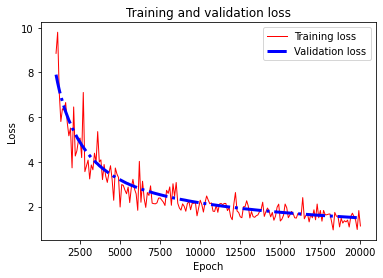

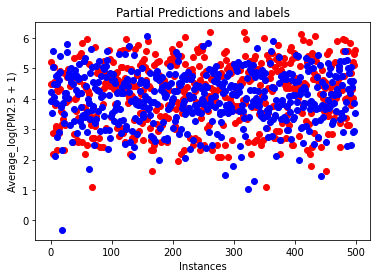

Average RMSE: 1.2283387


In [162]:
train_losses = []
val_losses = []
select_epoch_from = 1000
epochs = []
batch_iteration = int(len(X_train) / batch_size) + 1
with tf.Session() as sess: 
    sess.run(init)
    start_time = time.clock() 
    #Training epoch 
    for epoch in range(1,number_epochs+1):
        
        n = epoch % batch_iteration
        s = 0 + batch_size * n
        if n == 0:
           e = len(X_train)
        else:
           e = batch_size + batch_size * n
        
        batch_X = np.array(X_train[s:e])
        batch_y = np.array(y_train[s:e])

        _, train_loss = sess.run([optimizer, loss_func], feed_dict={X_p: batch_X, Y_p: batch_y})

        val_loss = loss_func.eval({X_p: X_val, Y_p: y_val})

        if epoch >= select_epoch_from and epoch % 100 == 0:
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            epochs.append(epoch)

        #Display the epoch
        if epoch % 1000 == 0:
            print("Epoch: %d, "
                  "Training loss: %s, "
                  "Validation loss: %s, " % (epoch, train_loss, val_loss))
    end_time = time.clock()
    print("The totoal training time is: " + str(end_time-start_time))

    pyplot.plot(epochs, train_losses, 'r', label='Training loss', linewidth=1, linestyle='-')
    pyplot.plot(epochs, val_losses, 'b', label='Validation loss', linewidth=3, linestyle='-.')
    pyplot.xlabel('Epoch') 
    pyplot.ylabel('Loss')
    pyplot.title('Training and validation loss')
    pyplot.legend()
    pyplot.figure()
    
    # Test model
    pred = (neural_network) 
    output=neural_network.eval({X_p: X_test}) 

    # plot prediction and labels
    pyplot.plot(y_test[0:500], 'ro', label='Testing labels')
    pyplot.plot(output[0:500], 'bo', label='Predictions')
    pyplot.xlabel('Instances') 
    pyplot.ylabel('Average_log(PM2.5 + 1)')
    pyplot.title('Partial Predictions and labels')
    pyplot.show()

    # final RMSE
    rmse_score = sess.run(eval_RMSE,feed_dict={X_p:X_test,Y_p:y_test})
    print("Average RMSE: " + str(rmse_score))